In [185]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import random                   
import pickle


In [186]:
try:
    counties = gpd.read_file("better_sil2.shp")
    with open('current_neighbours.data', 'rb') as fd2:
        curr_neighbours = pickle.load(fd2)
    with open('conquered.data', 'rb') as fd3:
        conquered = pickle.load(fd3)
    with open('neighbours.data', 'rb') as fd1:
        neighbours = pickle.load(fd1)
except:
    logging.error('Cannot read required files!')
    exit()



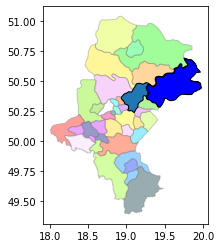

In [201]:
war_bot = BOT(counties, curr_neighbours, conquered, neighbours)

try:
    if war_bot.is_gameover():
        war_bot.close()
        exit()

    war_bot.simulate()
    war_bot.close()
    
except:
    war_bot.close()


In [199]:
class BOT:
    def __init__(self, counties, curr_neighbours, conquered, neighbours):
        self.counties = counties
        self.conquered = conquered
        self.curr_neighbours = curr_neighbours
        self.neighbours = neighbours
        self.counties_num = 36
        self.attacker = None
        self.territory = None
        self.deffender = None

    def find_attacker(self):
        players = []
        scores = []
        for i in range(self.counties_num):
            if len(self.conquered[i]) > 0:
                players.append(i)
                scores.append(self.get_score(i))
        sum_scores = sum(scores)
        scores = list(map(lambda x: x/sum_scores, scores))
        self.attacker = np.random.choice(players, p=scores)    
    
    def find_deffender(self):
        for owner in range(self.counties_num):
            if self.territory in self.conquered[owner]:
                self.deffender = owner
                return
    
    def find_territory(self):
            self.territory = random.choice(self.curr_neighbours[self.attacker])

    def is_gameover(self):
        for i in range(self.counties_num):
            if len(self.conquered[i]) == self.counties_num:
                return True
        return False

    def is_in_game(self, county):
        return len(self.conquered[county]) > 0

    def reset(self):
        self.curr_neighbours = self.neighbours
        for i in range(self.counties_num):
            self.conquered[i] = [i]
            self.counties.loc[i, 'OWNER'] = i

    def save_ranking(self):
        scores = []
        conq = []

        for i in range(self.counties_num):
            scores.append(self.get_score(i))
            conq.append(len(self.conquered[i]))
        ranking = pd.DataFrame(self.counties['NAME_2'])
        ranking.loc[:, 'Score'] = scores
        ranking.loc[:, 'Counquered territories'] = conq
        ranking.to_csv("ranking")

    def get_score(self, county):
        territories = self.conquered[county]
        score = 0
        for ter in territories:
            score += float(self.counties.loc[ter, 'Score'])
        return score

    def remove_territory_from_loser(self):
        self.conquered[self.deffender].remove(self.territory)
        self.update_neighbours(self.deffender)

    def add_territory_to_winner(self):
        self.counties.loc[self.territory, 'OWNER'] = self.attacker
        self.conquered[self.attacker].append(self.territory)
        self.update_neighbours(self.attacker)

    def update_neighbours(self, county):
        curr = set()
        for subter in self.conquered[county]:
            for i in range(len(self.neighbours[subter])):
                curr.add(self.neighbours[subter][i])
        self.curr_neighbours[county] = list(curr)

    def plot_map(self):
        self.counties["Winner"] = None
        self.counties["Lost"] = None
        for i in self.conquered[self.attacker]:
            self.counties.loc[i, "Winner"] = 1
        self.counties.loc[self.territory, "Lost"] = 1

        fig, ax = plt.subplots(1)
        self.counties.plot(ax=ax, column = "OWNER", cmap = "gist_ncar", edgecolor = 'grey', alpha = 0.4)
        self.counties.plot(ax=ax, column = "Winner", edgecolor = 'black')
        self.counties.plot(ax=ax, column = "Lost", cmap = 'winter', edgecolor = 'black')
        
        plt.savefig("res.png")
        del self.counties["Winner"]
        del self.counties["Lost"]

    def save_result(self):
        res = open('res.txt', 'a')
        msg1 = "Powiat " + str(self.counties.loc[self.attacker, 'NAME_2']) + " podbił teren " + str(self.counties.loc[self.territory, 'NAME_2']) + " nalezacy wczesniej do " + str(self.counties.loc[self.deffender, 'NAME_2']) + "."
        res.write(msg1)
        if not self.is_in_game(self.deffender):
            msg2 = "Powiat " + str(self.counties.loc[self.deffender, 'NAME_2']) + " zostal calkowicie zniszczony."
            res.write(msg2)
        if self.is_gameover():
            msg3 = "Wszystkie powiaty zostaly podbite przez powiat " + str(self.counties.loc[self.attacker, 'NAME_2']) + ". Koniec gry."
            res.write(msg3)
        res.write("\n")
        res.close()
    
    def close(self):
        self.counties.to_file("better_sil2.shp")
        with open('neighbours.data', 'wb') as fd1:
            pickle.dump(self.neighbours, fd1)
        with open('current_neighbours.data', 'wb') as fd2:
            pickle.dump(self.curr_neighbours,fd2)
        with open('conquered.data', 'wb') as fd3:
            pickle.dump(self.conquered, fd3)
        fd1.close()
        fd2.close()
        fd3.close()
        fd4.close()
    
    def simulate(self):
        self.find_attacker()
        self.find_territory()
        self.find_deffender()

        self.remove_territory_from_loser()
        self.add_territory_to_winner()

        self.plot_map()
        self.save_result()
        self.save_ranking()
        